# This NoteBook is for Preprocessing the External Image Dataset

# Importing packages

In [141]:
import os

import pandas as pd
import numpy as np

import cv2
import matplotlib.pylab as plt

from glob import glob as glob
from pathlib import Path


# Preprocessing Images

In [142]:
crack_srcdir = Path("../data/external/Crack")
noncrack_srcdir = Path("../data/external/Non-crack")

processed_dir = Path("../data/processed/pro_crack_img")
processed_dir.mkdir(parents=True, exist_ok=True)

In [143]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [144]:
crack_df = generate_df(crack_srcdir, label="CRACK_IMAGE")
noncrack_df = generate_df(noncrack_srcdir,label="NONCRACK_IMAGE")
total_df = pd.concat([crack_df,noncrack_df],axis=0).sample(frac=1.0,random_state=1).reset_index(drop=True)

total_df

,Filepath,Label
0,..\data\external\Crack\03842.jpg,CRACK_IMAGE
1,..\data\external\Crack\12899_1.jpg,CRACK_IMAGE
2,..\data\external\Crack\15033_1.jpg,CRACK_IMAGE
3,..\data\external\Non-crack\16782.jpg,NONCRACK_IMAGE
4,..\data\external\Crack\09202.jpg,CRACK_IMAGE
...,...,...
39995,..\data\external\Crack\07814.jpg,CRACK_IMAGE
39996,..\data\external\Non-crack\12512.jpg,NONCRACK_IMAGE
39997,..\data\external\Crack\05193.jpg,CRACK_IMAGE
39998,..\data\external\Crack\12173_1.jpg,CRACK_IMAGE


# Original Images Displaying

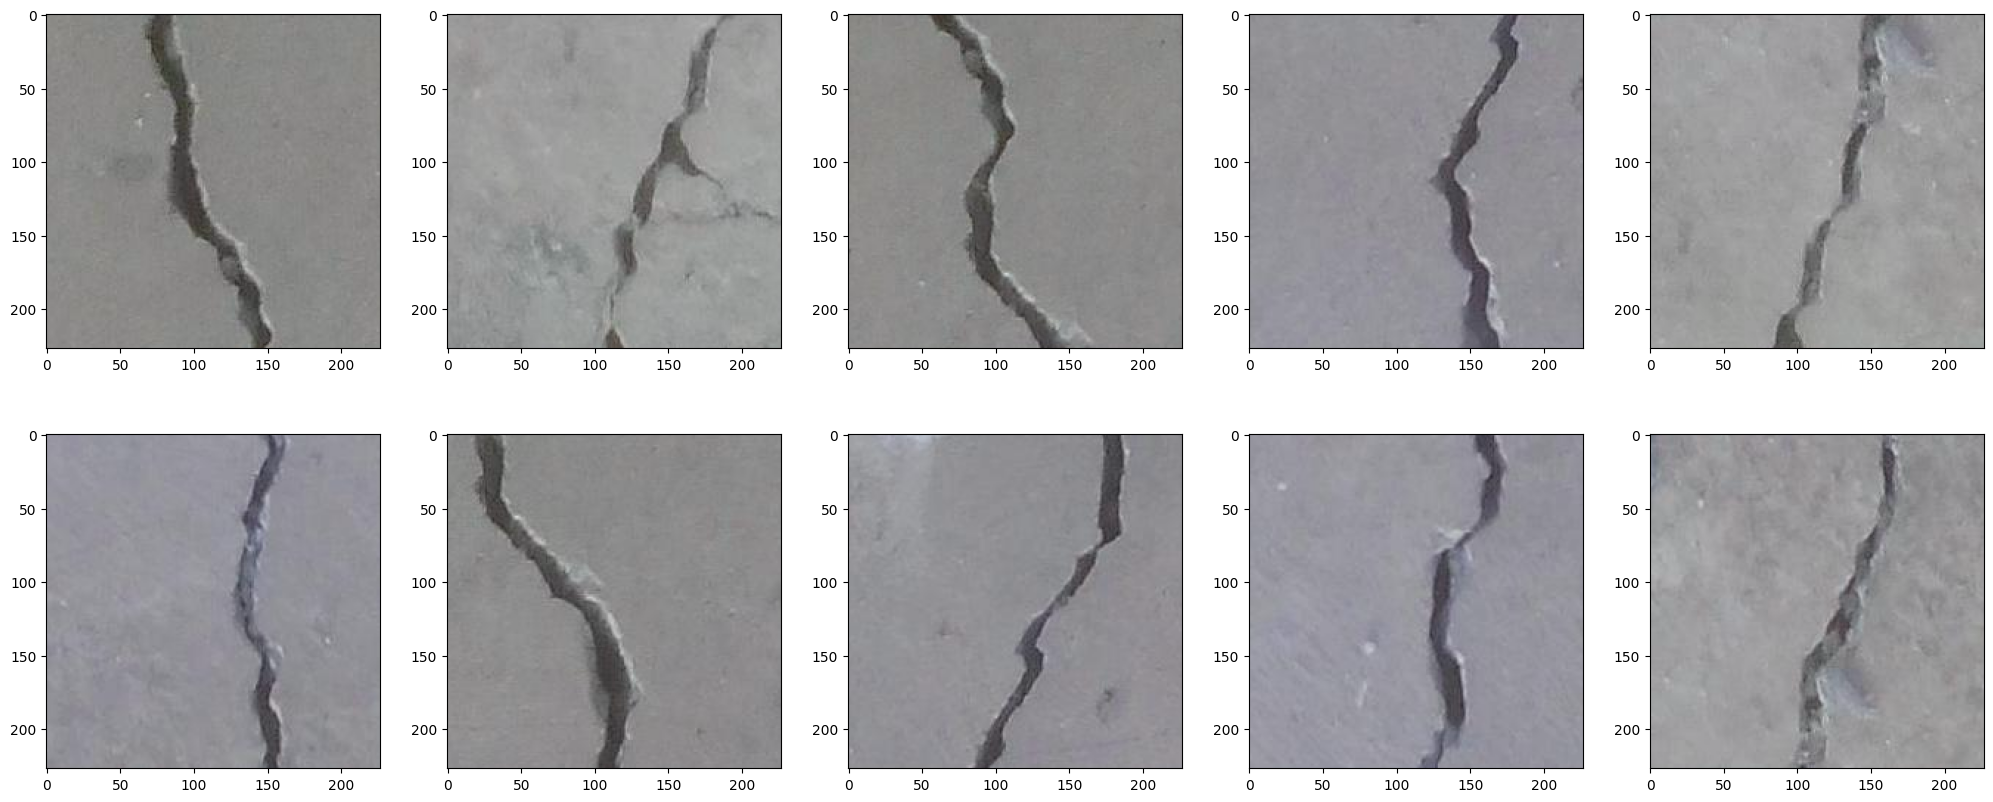

In [145]:
size = len(crack_df)
rows=2
cols = 5
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols,5*rows))

for i in range(rows):
    for j in range(cols):        
        if img_count <size:
            axes[i, j].imshow(cv2.imread(os.path.join(crack_srcdir, os.listdir(crack_srcdir)[img_count])))
            img_count+=1

# Adaptive Canny and Flood-Fill algorithm

In [146]:
def preprocess_image(image_path):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    blurred = cv2.bilateralFilter(img, 9, 30, 30)
    
    # Apply edge detection
    edges = cv2.Canny(blurred, 10, 150)

    # Dilation to enhance connectivity
    kernel = np.ones((2, 2), np.uint8)  
    dilated = cv2.dilate(edges, kernel, iterations=2)

    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=15)
    
    # Invert the image so cracks become black and background is white
    inverted = cv2.bitwise_not(closed)
    
    
    # 🔹 Flood Fill the Background
    h, w = inverted.shape
    mask = np.ones((h+2, w+2), dtype=np.uint8)  # Mask for floodFill
    
    # Fill the background (assumed to be white in `inverted`)
    cv2.floodFill(inverted, mask, (1, 1), 0)

    # Invert back so cracks remain white
    filled_cracks = cv2.bitwise_not(inverted)

    return filled_cracks

In [147]:
def plot_images(images, title, category):
    cols = 5
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap="gray")
        ax.set_title(f"{category} Image {i+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

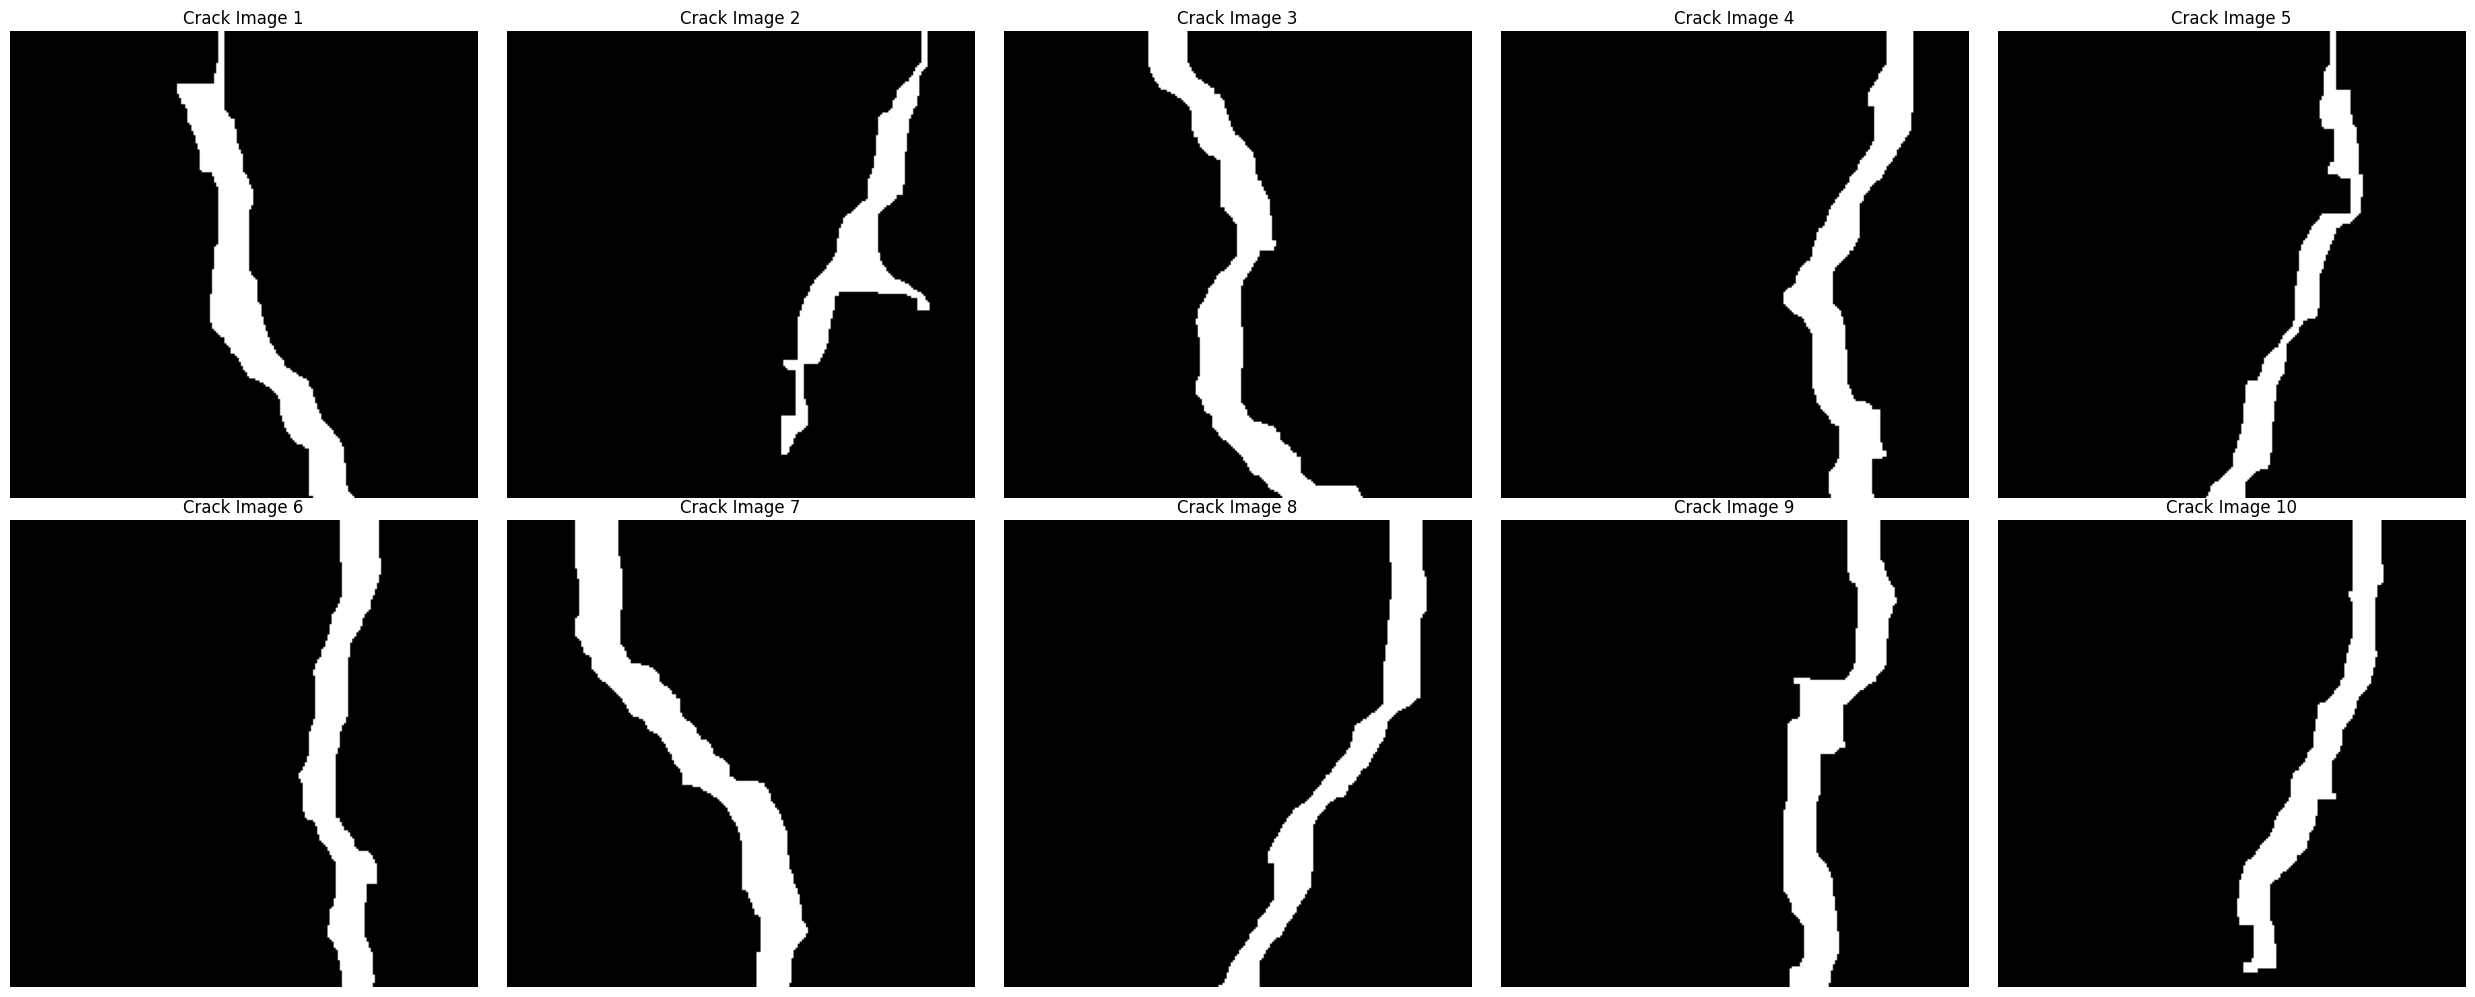

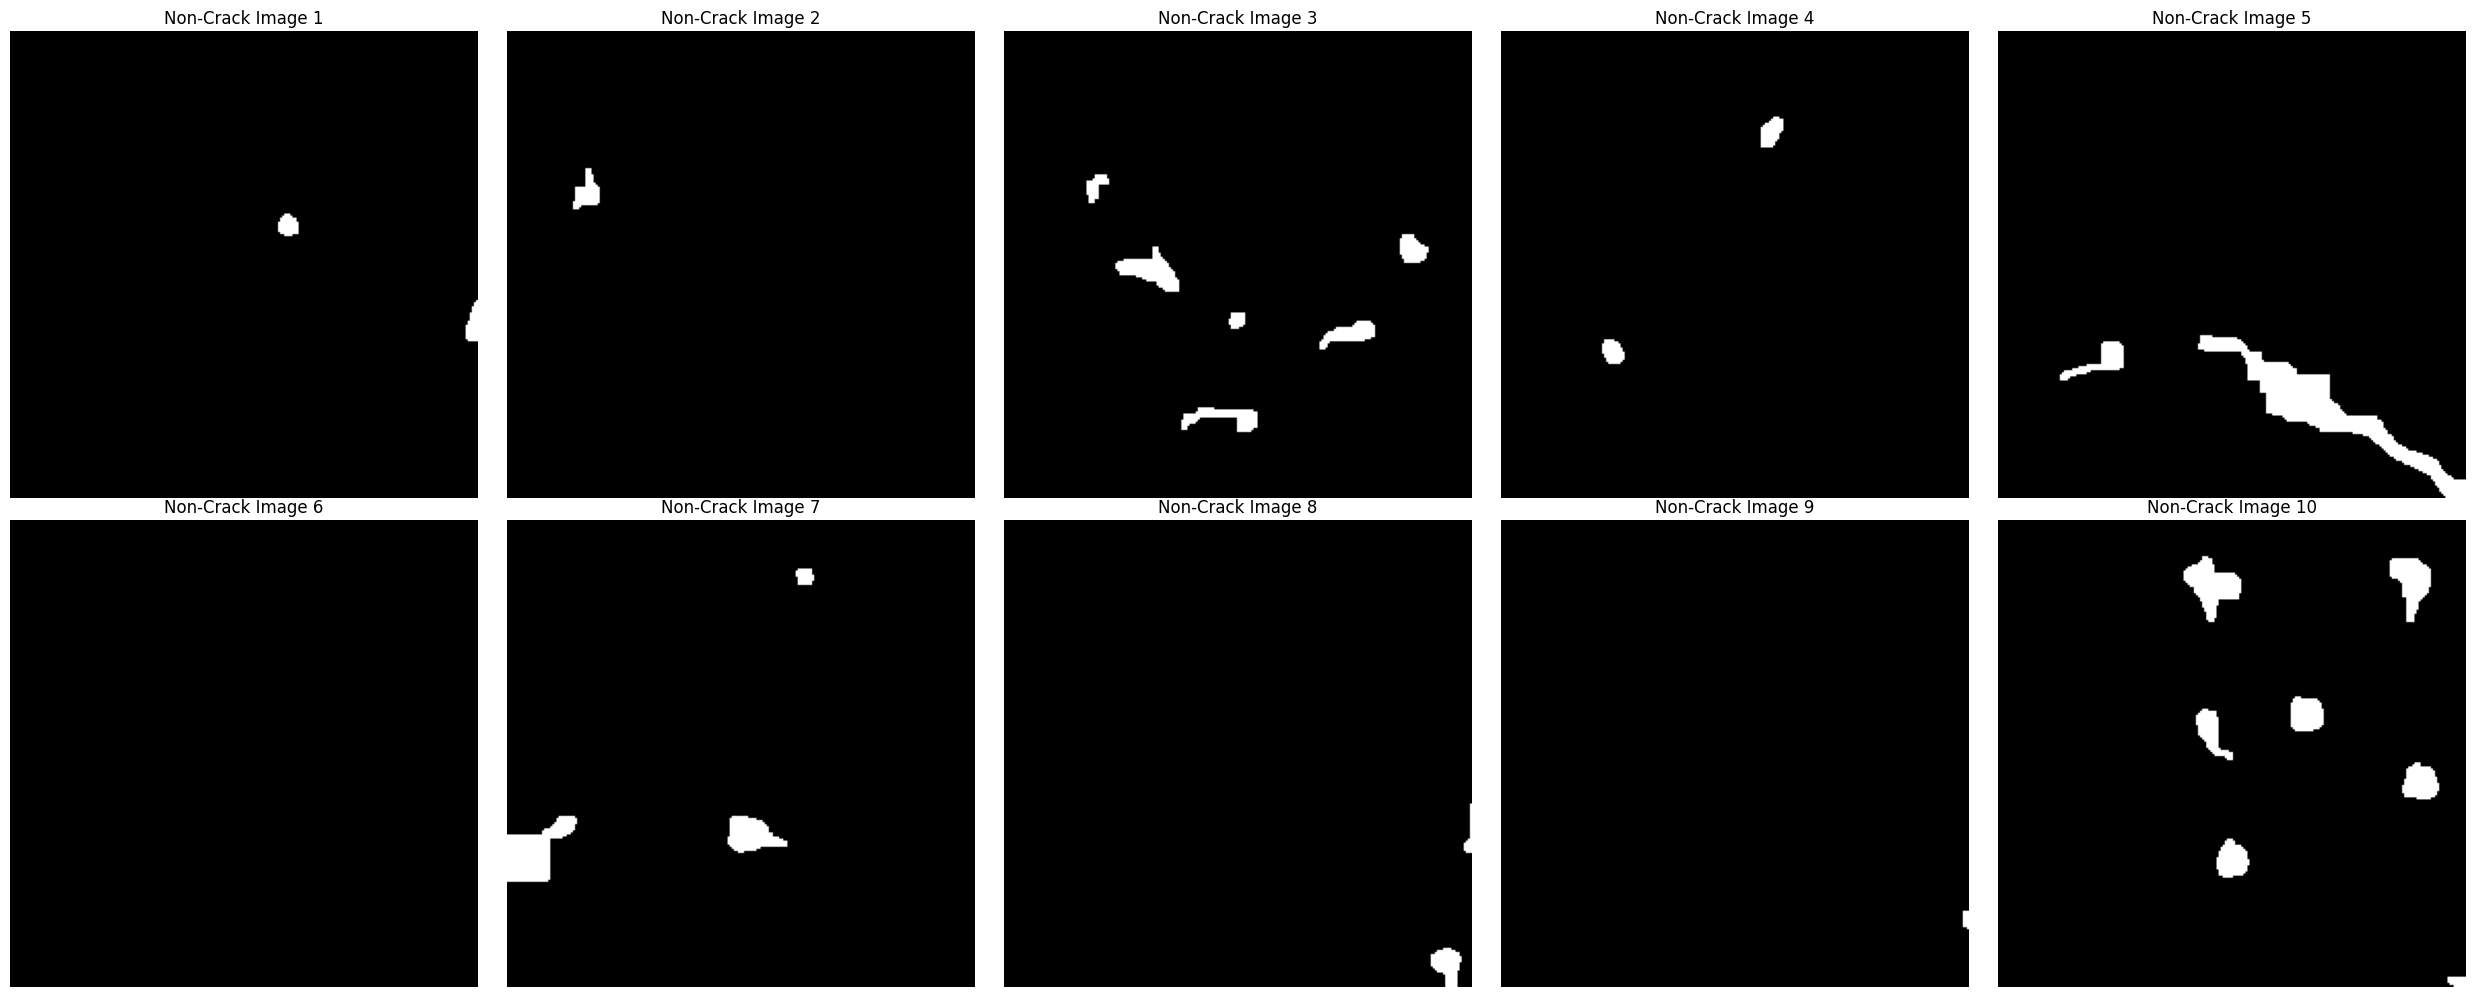

In [148]:
# Process and visualize first 10 Crack images
crack_images = list(crack_srcdir.glob("*.jpg"))[:10]
crack_processed = [preprocess_image(img) for img in crack_images]
plot_images(crack_processed, crack_images, "Crack")

# Save after visualization
for i, image_path in enumerate(crack_images):
    output_path = processed_dir / image_path.name
    cv2.imwrite(str(output_path), crack_processed[i])

# Process and visualize first 10 Non-Crack images
noncrack_images = list(noncrack_srcdir.glob("*.jpg"))[:10]
noncrack_processed = [preprocess_image(img) for img in noncrack_images]
plot_images(noncrack_processed, noncrack_images, "Non-Crack")


# PREPROCESSING COMPLETED